<a href="https://colab.research.google.com/github/jumacaq/Data_Telecom_Churn/blob/master/Data_telecom_churn_jcq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**1. Configuración del Ambiente**

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
global datos_churn

#**2. Obtención y Tratamiento de Datos**

## 2.1 Cargando las bases de datos

In [ ]:
datos_churn = pd.read_json("/content/drive/MyDrive/ bootcamp experience/setiembre 2024/DS_Telecom_Churn/base_clientes.json")
datos_churn.head()

,id_cliente,Churn,cliente,telefono,internet,cuenta
0,0002-ORFBO,no,"{'genero': 'femenino', 'anciano': 0, 'pareja':...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'DSL', 'seguridad_online...","{'contrato': None, 'facturacion_electronica': ..."
1,0003-MKNFE,no,"{'genero': 'masculino', 'anciano': 0, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'DSL', 'seguridad_online...","{'contrato': 'mensual', 'facturacion_electroni..."
2,0004-TLHLJ,si,"{'genero': 'masculino', 'anciano': 0, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."
3,0011-IGKFF,si,"{'genero': 'masculino', 'anciano': 1, 'pareja'...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."
4,0013-EXCHZ,si,"{'genero': 'femenino', 'anciano': 1, 'pareja':...","{'servicio_telefono': 'si', 'varias_lineas': '...","{'servicio_internet': 'fibra optica', 'segurid...","{'contrato': 'mensual', 'facturacion_electroni..."


In [ ]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_cliente  7344 non-null   object
 1   Churn       7344 non-null   object
 2   cliente     7344 non-null   object
 3   telefono    7344 non-null   object
 4   internet    7344 non-null   object
 5   cuenta      7344 non-null   object
dtypes: object(6)
memory usage: 344.4+ KB


### Información del diccionario de datos

In [ ]:
with open('/content/drive/MyDrive/ bootcamp experience/setiembre 2024/DS_Telecom_Churn/Diccionario.txt', 'r', encoding='utf-8') as file:
    contenido = file.read()
print(contenido)

La base de datos contiene columnas además del ID de los clientes y el churn:

Cliente:
género: género (masculino y femenino)
anciano: información sobre si un cliente tiene o no una edad igual o mayor a 65 años
pareja: si el cliente tiene o no una pareja
dependientes: si el cliente tiene o no dependientes
tiempo_servicio: meses de contrato del cliente

Servicio de telefonía:
servicio_telefono: suscripción al servicio telefónico
varias_lineas: suscripción a más de una línea telefónica

Servicio de internet:
servicio_internet: suscripción a un proveedor de internet
seguridad_online: suscripción adicional a seguridad en línea
backup_online: suscripción adicional a copias de seguridad en línea
proteccion_dispositivo: suscripción adicional a protección en el dispositivo
soporte_tecnico: suscripción adicional a soporte técnico, menos tiempo de espera
tv_streaming: suscripción a TV por cable
peliculas_streaming: suscripción a streaming de películas

Cuenta:
contrato: tipo de contrato
factura_e

Creamos la función `lectura_datos()` para tranformar la base de datos de un archivo j-son a dataframe mediante el método `json_normalize`

In [ ]:
def lectura_datos():
  global datos_churn
  with open('/content/drive/MyDrive/ bootcamp experience/setiembre 2024/DS_Telecom_Churn/base_clientes.json') as f:
    datos_brutos = json.load(f)
    datos_churn = pd.json_normalize(datos_brutos)
  return datos_churn

In [ ]:
lectura_datos()

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,0002-ORFBO,no,femenino,0,si,si,9.0,si,no,DSL,no,si,no,si,si,no,None,None,None,NaN,None
1,0003-MKNFE,no,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.90,542.4
2,0004-TLHLJ,si,masculino,0,no,no,4.0,si,no,fibra optica,no,no,si,no,no,no,mensual,si,cheque electronico,73.90,280.85
3,0011-IGKFF,si,masculino,1,si,no,13.0,si,no,fibra optica,no,si,si,no,si,si,mensual,si,cheque electronico,98.00,1237.85
4,0013-EXCHZ,si,femenino,1,si,no,3.0,si,no,fibra optica,no,no,no,si,si,no,mensual,si,cheque,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7339,5172-RKOCB,no,masculino,0,si,no,72.0,si,si,fibra optica,si,si,no,si,si,si,dos años,si,tarjeta de credito (automatico),108.95,7875
7340,1934-MKPXS,no,masculino,0,si,si,33.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,un año,no,tarjeta de credito (automatico),20.10,620.55
7341,5959-BELXA,si,masculino,1,no,no,32.0,si,si,fibra optica,no,no,no,no,si,si,mensual,si,tarjeta de credito (automatico),96.15,3019.25
7342,3601-UTZXO,,masculino,0,si,si,41.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,un año,no,transferencia bancaria (automatica),19.50,798.2


In [ ]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7344 entries, 0 to 7343
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7344 non-null   object 
 1   Churn                            7344 non-null   object 
 2   cliente.genero                   7344 non-null   object 
 3   cliente.anciano                  7344 non-null   int64  
 4   cliente.pareja                   7344 non-null   object 
 5   cliente.dependientes             7344 non-null   object 
 6   cliente.tiempo_servicio          7336 non-null   float64
 7   telefono.servicio_telefono       7344 non-null   object 
 8   telefono.varias_lineas           7344 non-null   object 
 9   internet.servicio_internet       7344 non-null   object 
 10  internet.seguridad_online        7344 non-null   object 
 11  internet.backup_online           7344 non-null   object 
 12  internet.proteccion_

## 2.2 Tratamiento de datos

In [ ]:
# Revisamos los valores estadísticos de las colummnas numéricas
datos_churn.describe()

,cliente.anciano,cliente.tiempo_servicio,cuenta.cobros.mensual
count,7344.000000,7336.000000,7326.000000
mean,0.162990,33.271265,64.683770
std,0.369382,35.776684,30.143033
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.362500
50%,0.000000,29.000000,70.300000
75%,0.000000,56.000000,89.887500
max,1.000000,1080.000000,118.750000


In [ ]:
datos_churn['Churn'].value_counts()

,count
Churn,
no,5223
si,1895
,226


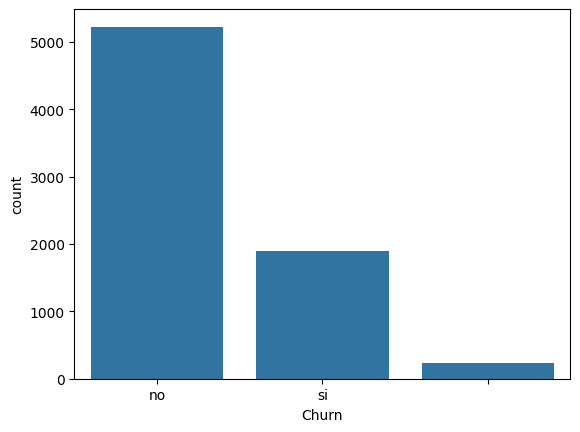

In [ ]:
# Creamos un gréfico de barras para ver la distribucion de la columna 'Churn'
sns.countplot(x='Churn', data=datos_churn)
plt.show()

In [ ]:
# Eliminamos los registros que tengan valores distintos a 'si' o 'no' en la columna'Churn'
datos_churn = datos_churn[datos_churn['Churn'].isin(['si', 'no'])]
datos_churn.shape

(7118, 21)

In [ ]:
#Reemplazo los valores vacios en 'cuenta.cobros.Total' por Nan y cambio los valores a float
datos_churn['cuenta.cobros.Total'] = datos_churn['cuenta.cobros.Total'].replace(['', ' '], np.nan).astype(float)
datos_churn['cuenta.cobros.mensual'] = datos_churn['cuenta.cobros.mensual'].replace(['', ' '], np.nan)

<ipython-input-155-00db2ec9649e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_churn['cuenta.cobros.Total'] = datos_churn['cuenta.cobros.Total'].replace(['', ' '], np.nan).astype(float)
<ipython-input-155-00db2ec9649e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos_churn['cuenta.cobros.mensual'] = datos_churn['cuenta.cobros.mensual'].replace(['', ' '], np.nan)


In [ ]:
#Mostramos los valores
datos_churn[(datos_churn["cuenta.cobros.Total"].isna()) & (datos_churn["cuenta.cobros.mensual"].isna())].loc[:,["cliente.tiempo_servicio","cuenta.contrato","cuenta.cobros.mensual","cuenta.cobros.Total"]]

,cliente.tiempo_servicio,cuenta.contrato,cuenta.cobros.mensual,cuenta.cobros.Total
0,9.0,None,NaN,NaN
1646,23.0,None,NaN,NaN
1647,55.0,None,NaN,NaN
2087,40.0,None,NaN,NaN
4852,5.0,None,NaN,NaN
4856,62.0,None,NaN,NaN
4862,1.0,None,NaN,NaN
4874,56.0,None,NaN,NaN
4896,18.0,None,NaN,NaN
5567,22.0,None,NaN,NaN


In [ ]:
idx = datos_churn[(datos_churn["cuenta.cobros.Total"].isna()) & (datos_churn["cuenta.cobros.mensual"].isna())].index
idx

Index([0, 1646, 1647, 2087, 4852, 4856, 4862, 4874, 4896, 5567, 5569, 7299], dtype='int64')

In [ ]:
datos_churn = datos_churn.drop(idx)
datos_churn.shape

(7106, 21)

<Axes: >

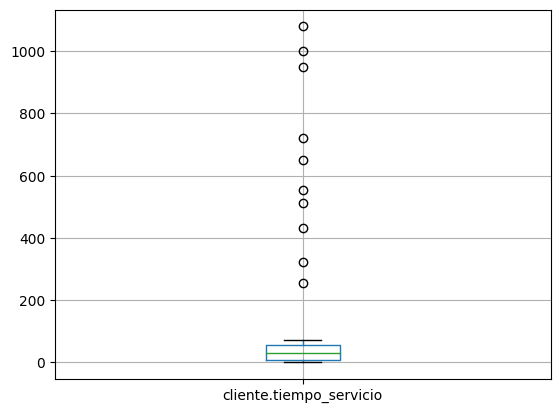

In [ ]:
# Verificamos que hay inconsistencias en la columna 'cliente.tiempo_servicio', con clientes con más de 200 meses de de servicio e incluso 1080 meses
datos_churn.boxplot(['cliente.tiempo_servicio'])

In [ ]:
mode = datos_churn['cliente.tiempo_servicio'].mode()[0]
print(mode)

1.0


In [ ]:
#Definición de la función `preprocesamiento()`:
def preprocesamiento():
  global datos_churn
  # Eliminamos los registros que tengan valores distintos a 'si' o 'no' en la columna'Churn'
  datos_churn = datos_churn[datos_churn['Churn'].isin(['si', 'no'])]
  #Reemplazo los valores vacios en 'cuenta.cobros.Total' por Nan y cambio los valores a float
  datos_churn['cuenta.cobros.Total'] = datos_churn['cuenta.cobros.Total'].replace(['', ' '], np.nan).astype(float)
  #Reemplazo los valores vacios en 'cuenta.cobros.mensual' por Nan
  datos_churn['cuenta.cobros.mensual'] = datos_churn['cuenta.cobros.mensual'].replace(['', ' '], np.nan)
  # Imputación de valores en 'cliente.tiempo_servicio' basado en otras columnas
  # Si el valor está ausente, se utiliza la relación: 'cuenta.cobros.Total' = 'cliente.tiempo_servicio' * 'cuenta.cobros.mensual'
  datos_churn['cliente.tiempo_servicio'] = np.where(
      datos_churn['cliente.tiempo_servicio'].isna(),
      datos_churn['cuenta.cobros.Total'] / datos_churn['cuenta.cobros.mensual'],
      datos_churn['cliente.tiempo_servicio']
    )

  # Imputación de valores en 'cuenta.cobros.Total' basado en 'cliente.tiempo_servicio'
  # Si 'cuenta.cobros.Total' es NaN y 'cliente.tiempo_servicio' es distinto de 0, se aplica la relación: 'cuenta.cobros.Total' = 'cliente.tiempo_servicio' * 'cuenta.cobros.mensual'
  datos_churn["cuenta.cobros.Total"] = np.where(
      (datos_churn["cuenta.cobros.Total"].isna()) & (datos_churn["cliente.tiempo_servicio"] != 0.0),
      datos_churn['cliente.tiempo_servicio'] * datos_churn['cuenta.cobros.mensual'],
       datos_churn["cuenta.cobros.Total"]
    )

  # Imputación de valores en 'cuenta.contrato' basado en 'cliente.tiempo_servicio'
  # Se imputa el tipo de contrato basándose en la duración del servicio, utilizando descripciones estadísticas de los datos
  datos_churn['cuenta.contrato'] = np.where(
      datos_churn['cuenta.contrato'].isna() & (datos_churn['cliente.tiempo_servicio'] <= 28),
      'mensual',
      np.where(
          datos_churn['cuenta.contrato'].isna() & (datos_churn['cliente.tiempo_servicio'] > 28) & (datos_churn['cliente.tiempo_servicio'] <= 53),
          'un año',
          np.where(
                datos_churn['cuenta.contrato'].isna() & (datos_churn['cliente.tiempo_servicio'] > 53),
                'dos años',
                datos_churn['cuenta.contrato']
            )
        )
    )

  # Imputación de valores en 'cuenta.cobros.mensual' cuando es NaN
  # Si el valor está ausente, se aplica la relación: 'cuenta.cobros.Total' = 'cliente.tiempo_servicio' * 'cuenta.cobros.mensual'
  datos_churn["cuenta.cobros.mensual"] = np.where(
      datos_churn["cuenta.cobros.mensual"].isna(),
      datos_churn["cuenta.cobros.Total"] / datos_churn["cliente.tiempo_servicio"],
      datos_churn["cuenta.cobros.mensual"]
  )

  # Imputación de valores faltantes en 'cuenta.facturacion_electronica' y 'cuenta.metodo_pago' utilizando la moda
  datos_churn['cuenta.facturacion_electronica'].fillna(datos_churn['cuenta.facturacion_electronica'].mode()[0], inplace=True)
  datos_churn['cuenta.metodo_pago'].fillna(datos_churn['cuenta.metodo_pago'].mode()[0], inplace=True)

  # Restablecer el índice del DataFrame después de las eliminaciones
  datos_churn = datos_churn.reset_index(drop=True)

  # llenar col cuenta.cobros.Total con nulos:
  '''def calcular_cobros_total(row):
    if pd.isnull(row['cuenta.cobros.Total']):
      if row['cliente.tiempo_servicio'] == 0:
        return row['cuenta.cobros.mensual']
      else:
        return row['cuenta.cobros.mensual'] * row['cliente.tiempo_servicio']
    else:
      return row['cuenta.cobros.Total']
  datos_churn['cuenta.cobros.Total'] = datos_churn.apply(calcular_cobros_total, axis=1)
  datos_churn.dropna(subset='cuenta.cobros.Total', inplace=True)'''

  # Imputamos los valores nulos en columna 'cuenta.contrato' con el valos moda
  contrato_mode = datos_churn['cuenta.contrato'].mode()[0]
  datos_churn['cuenta.contrato'].fillna(contrato_mode, inplace=True)
  # Se calculan los cuartiles Q1 y Q3 para la columna `cliente.tiempo_servicio`
  Q1 = datos_churn['cliente.tiempo_servicio'].quantile(0.25)
  Q3 = datos_churn['cliente.tiempo_servicio'].quantile(0.75)
  # Calculo del rango intercuantílico
  IQR = Q3 - Q1
  # Se establecen límites inferior y superior para identificar outliers de la columna `cliente.tiempo_servicio`.
  limite_inf = Q1 - 1.5 * IQR
  limite_sup = Q3 + 1.5 * IQR
  # Imputamos los outliers en 'cliente.tiempo_servicio' con el valor moda
  mode = datos_churn['cliente.tiempo_servicio'].mode()[0]
  datos_churn['cliente.tiempo_servicio'] = datos_churn['cliente.tiempo_servicio'].apply(
    lambda x: mode if x < limite_inf else mode  if x > limite_sup else x
  )
  #datos_churn['cliente.tiempo_servicio'] = datos_churn['cliente.tiempo_servicio'].fillna(datos_churn['cuenta.cobros.Total']/datos_churn['cuenta.cobros.mensual'])
  median_cobros_total = datos_churn['cuenta.cobros.Total'].median()
  #Imputamos los valores nulos con la mediana
  datos_churn['cuenta.cobros.Total'].fillna(median_cobros_total, inplace=True)
  # Calcular la mediana de la columna'cuenta.cobros.mensual'
  median_cobros_mensual = datos_churn['cuenta.cobros.mensual'].median()
  # Imputar los valores nulos con la mediana
  datos_churn['cuenta.cobros.mensual'].fillna(median_cobros_mensual, inplace=True)
  # Calcular la moda de la columna'cuenta.facturacion_electronica'
  moda_facturacion_electronica = datos_churn['cuenta.facturacion_electronica'].mode()[0]
  # Imputar los valores nulos con la moda
  datos_churn['cuenta.facturacion_electronica'].fillna(moda_facturacion_electronica, inplace=True)
  # Calcular la moda de 'metodo_pago'
  moda_metodo_pago = datos_churn['cuenta.metodo_pago'].mode()[0]
  # Imputar los valores nulos con la moda
  datos_churn['cuenta.metodo_pago'].fillna(moda_metodo_pago, inplace=True)
  #datos_churn = datos_churn.dropna(subset=['cuenta.contrato', 'cuenta.facturacion_electronica', 'cuenta.metodo_pago'])
  datos_churn = datos_churn.reset_index(drop=True)

  return datos_churn


preprocesamiento()

<ipython-input-161-27c01bb70eb7>:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  datos_churn['cuenta.facturacion_electronica'].fillna(datos_churn['cuenta.facturacion_electronica'].mode()[0], inplace=True)
<ipython-input-161-27c01bb70eb7>:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

,id_cliente,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,telefono.varias_lineas,internet.servicio_internet,internet.seguridad_online,internet.backup_online,internet.proteccion_dispositivo,internet.soporte_tecnico,internet.tv_streaming,internet.peliculas_streaming,cuenta.contrato,cuenta.facturacion_electronica,cuenta.metodo_pago,cuenta.cobros.mensual,cuenta.cobros.Total
0,0003-MKNFE,no,masculino,0,no,no,9.0,si,si,DSL,no,no,no,no,no,si,mensual,no,cheque,59.90,542.40
1,0004-TLHLJ,si,masculino,0,no,no,4.0,si,no,fibra optica,no,no,si,no,no,no,mensual,si,cheque electronico,73.90,280.85
2,0011-IGKFF,si,masculino,1,si,no,13.0,si,no,fibra optica,no,si,si,no,si,si,mensual,si,cheque electronico,98.00,1237.85
3,0013-EXCHZ,si,femenino,1,si,no,3.0,si,no,fibra optica,no,no,no,si,si,no,mensual,si,cheque,83.90,267.40
4,0013-MHZWF,no,femenino,0,no,si,9.0,si,no,DSL,no,no,no,si,si,si,mensual,si,tarjeta de credito (automatico),69.40,571.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101,5792-JALQC,no,femenino,1,no,no,52.0,si,si,DSL,si,no,si,no,no,no,dos años,no,transferencia bancaria (automatica),59.85,3103.25
7102,5172-RKOCB,no,masculino,0,si,no,72.0,si,si,fibra optica,si,si,no,si,si,si,dos años,si,tarjeta de credito (automatico),108.95,7875.00
7103,1934-MKPXS,no,masculino,0,si,si,33.0,si,no,no,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,sin servicio de internet,un año,no,tarjeta de credito (automatico),20.10,620.55
7104,5959-BELXA,si,masculino,1,no,no,32.0,si,si,fibra optica,no,no,no,no,si,si,mensual,si,tarjeta de credito (automatico),96.15,3019.25


In [ ]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7106 entries, 0 to 7105
Data columns (total 21 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   id_cliente                       7106 non-null   object 
 1   Churn                            7106 non-null   object 
 2   cliente.genero                   7106 non-null   object 
 3   cliente.anciano                  7106 non-null   int64  
 4   cliente.pareja                   7106 non-null   object 
 5   cliente.dependientes             7106 non-null   object 
 6   cliente.tiempo_servicio          7106 non-null   float64
 7   telefono.servicio_telefono       7106 non-null   object 
 8   telefono.varias_lineas           7106 non-null   object 
 9   internet.servicio_internet       7106 non-null   object 
 10  internet.seguridad_online        7106 non-null   object 
 11  internet.backup_online           7106 non-null   object 
 12  internet.proteccion_

## 2.3 Normalizacion de datos

In [ ]:
for col in datos_churn.columns:
    print(f"Columna: {col}")
    print(datos_churn[col].unique())
    print("-" * 30)

Columna: id_cliente
['0003-MKNFE' '0004-TLHLJ' '0011-IGKFF' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Columna: Churn
['no' 'si']
------------------------------
Columna: cliente.genero
['masculino' 'femenino']
------------------------------
Columna: cliente.anciano
[0 1]
------------------------------
Columna: cliente.pareja
['no' 'si']
------------------------------
Columna: cliente.dependientes
['no' 'si']
------------------------------
Columna: cliente.tiempo_servicio
[ 9.          4.         13.          3.         71.         63.
  7.         65.86954118 54.         72.          5.         56.
 34.          1.         45.         50.         23.         55.
 26.         69.         37.         49.         66.         67.
 20.         43.         59.         12.         27.          2.
 25.         29.         14.         35.         64.         39.
 40.         11.          6.         30.         70.         57.
 58.         16.         32.        

In [ ]:
def normalizacion():
  global datos_churn
  #Se elimina la columna `id_cliente` del DataFrame.
  datos_churn = datos_churn.drop(columns='id_cliente')
  #Buscamos las columnas que tengan solo valor Si ó No, para luego cambiarlas a números con un diccionario:
  datos_binarios = datos_churn[[col for col in datos_churn.columns if datos_churn[col].nunique() == 2]]
  #Se crea un diccionario que asigna valores numéricos a ciertas categorías: 'no' a 0, 'si' a 1, 'masculino' a 0 y 'femenino' a 1.
  maping = {'si': 1, 'no': 0, 'masculino':0,'femenino':1}
  #Se definen las columnas que serán normalizadas, todas las binarias excepto 'cliente.anciano' que ya es numérica
  columnas = ['Churn', 'cliente.genero',  'cliente.pareja',
       'cliente.dependientes', 'telefono.servicio_telefono',
       'cuenta.facturacion_electronica']
  #Se reemplazan las categorías en las columnas especificadas utilizando el diccionario de mapeo.
  datos_churn[columnas] = datos_churn[columnas].replace(maping)
  #Separamos las columnas numéricas del dataframe
  columnas_numericas = datos_churn.select_dtypes(include=['int64', 'float64'])
  #Aplicamos get_dummies a las columnas tipo object
  datos_dummies = pd.get_dummies(datos_churn.select_dtypes(include=['object'])).astype(int)
  #Concatenamos los dataframes
  datos_churn = pd.concat([columnas_numericas, datos_dummies], axis=1)
  # Se reinicia el índice del DataFrame, eliminando el índice anterior.
  datos_churn.reset_index(drop=True, inplace=True)
  return datos_churn


normalizacion()

<ipython-input-164-e7bb7ac5cb40>:14: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  datos_churn[columnas] = datos_churn[columnas].replace(maping)


,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,cuenta.facturacion_electronica,cuenta.cobros.mensual,cuenta.cobros.Total,telefono.varias_lineas_no,telefono.varias_lineas_si,telefono.varias_lineas_sin servicio de telefono,internet.servicio_internet_DSL,internet.servicio_internet_fibra optica,internet.servicio_internet_no,internet.seguridad_online_no,internet.seguridad_online_si,internet.seguridad_online_sin servicio de internet,internet.backup_online_no,internet.backup_online_si,internet.backup_online_sin servicio de internet,internet.proteccion_dispositivo_no,internet.proteccion_dispositivo_si,internet.proteccion_dispositivo_sin servicio de internet,internet.soporte_tecnico_no,internet.soporte_tecnico_si,internet.soporte_tecnico_sin servicio de internet,internet.tv_streaming_no,internet.tv_streaming_si,internet.tv_streaming_sin servicio de internet,internet.peliculas_streaming_no,internet.peliculas_streaming_si,internet.peliculas_streaming_sin servicio de internet,cuenta.contrato_dos años,cuenta.contrato_mensual,cuenta.contrato_un año,cuenta.metodo_pago_cheque,cuenta.metodo_pago_cheque electronico,cuenta.metodo_pago_tarjeta de credito (automatico),cuenta.metodo_pago_transferencia bancaria (automatica)
0,0,0,0,0,0,9.0,1,0,59.90,542.40,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0
1,1,0,0,0,0,4.0,1,1,73.90,280.85,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
2,1,0,1,1,0,13.0,1,1,98.00,1237.85,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,1,1,1,1,0,3.0,1,1,83.90,267.40,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0
4,0,1,0,0,1,9.0,1,1,69.40,571.45,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7101,0,1,1,0,0,52.0,1,0,59.85,3103.25,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
7102,0,0,0,1,0,72.0,1,1,108.95,7875.00,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
7103,0,0,0,1,1,33.0,1,0,20.10,620.55,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
7104,1,0,1,0,0,32.0,1,1,96.15,3019.25,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0


In [ ]:
datos_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7106 entries, 0 to 7105
Data columns (total 41 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Churn                                                     7106 non-null   int64  
 1   cliente.genero                                            7106 non-null   int64  
 2   cliente.anciano                                           7106 non-null   int64  
 3   cliente.pareja                                            7106 non-null   int64  
 4   cliente.dependientes                                      7106 non-null   int64  
 5   cliente.tiempo_servicio                                   7106 non-null   float64
 6   telefono.servicio_telefono                                7106 non-null   int64  
 7   cuenta.facturacion_electronica                            7106 non-null   int64  
 8   cuenta.cobros.mens

In [ ]:
datos_churn.head()

,Churn,cliente.genero,cliente.anciano,cliente.pareja,cliente.dependientes,cliente.tiempo_servicio,telefono.servicio_telefono,cuenta.facturacion_electronica,cuenta.cobros.mensual,cuenta.cobros.Total,telefono.varias_lineas_no,telefono.varias_lineas_si,telefono.varias_lineas_sin servicio de telefono,internet.servicio_internet_DSL,internet.servicio_internet_fibra optica,internet.servicio_internet_no,internet.seguridad_online_no,internet.seguridad_online_si,internet.seguridad_online_sin servicio de internet,internet.backup_online_no,internet.backup_online_si,internet.backup_online_sin servicio de internet,internet.proteccion_dispositivo_no,internet.proteccion_dispositivo_si,internet.proteccion_dispositivo_sin servicio de internet,internet.soporte_tecnico_no,internet.soporte_tecnico_si,internet.soporte_tecnico_sin servicio de internet,internet.tv_streaming_no,internet.tv_streaming_si,internet.tv_streaming_sin servicio de internet,internet.peliculas_streaming_no,internet.peliculas_streaming_si,internet.peliculas_streaming_sin servicio de internet,cuenta.contrato_dos años,cuenta.contrato_mensual,cuenta.contrato_un año,cuenta.metodo_pago_cheque,cuenta.metodo_pago_cheque electronico,cuenta.metodo_pago_tarjeta de credito (automatico),cuenta.metodo_pago_transferencia bancaria (automatica)
0,0,0,0,0,0,9.0,1,0,59.9,542.40,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0
1,1,0,0,0,0,4.0,1,1,73.9,280.85,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
2,1,0,1,1,0,13.0,1,1,98.0,1237.85,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,1,1,1,1,0,3.0,1,1,83.9,267.40,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0
4,0,1,0,0,1,9.0,1,1,69.4,571.45,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0


# **3. Entrenamiento del Modelo con Random Forest**

In [ ]:
y = datos_churn['Churn']
x = datos_churn.drop(columns='Churn')
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.3, random_state = 50)

In [ ]:
def pronosticar(train_x, train_y):
  model = RandomForestClassifier(random_state=50)
  model.fit(train_x, train_y)
  return model

model = pronosticar(train_x, train_y)
model.score(test_x, test_y,)

0.798311444652908

# **4. Reducción de Dimensionalidad**

## 4.1 Métodos Gráficos

In [ ]:
def diagrama_violin(df, inicio, fin):

    df_num = df[df.select_dtypes(include="int64").columns]
    y = df_num["Churn"]
    x = df_num.drop(columns="Churn")
    df = pd.concat([y, x.iloc[:,inicio:fin]], axis=1)

    df_melted = pd.melt(df, id_vars="Churn", var_name="features", value_name="valores")

    plt.figure(figsize=(12, 6))
    sns.violinplot(x="features", y="valores", hue="Churn", data=df_melted)
    plt.xticks(rotation=90)
    plt.show()

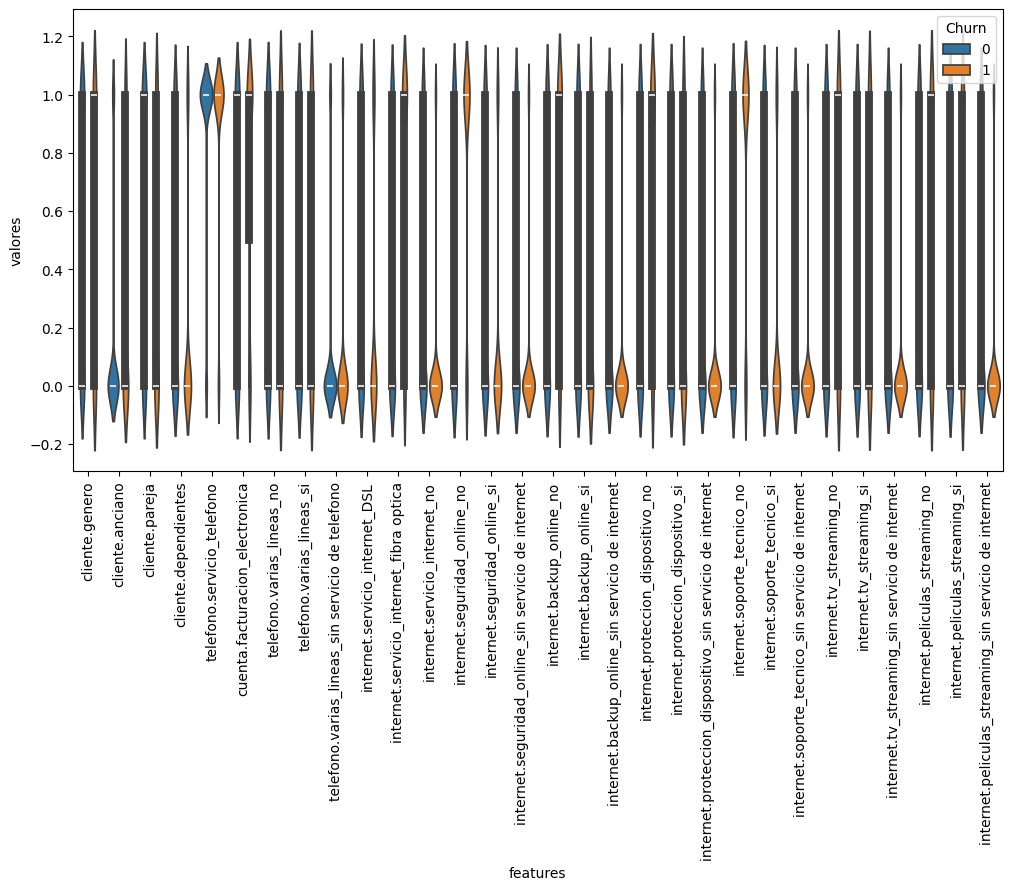

In [ ]:
diagrama_violin(datos_churn, 0, 30)

In [ ]:
def diagrama_puntos(df, inicio, fin):

    df_num = df[df.select_dtypes(include="int64").columns]
    y = df_num["Churn"]
    x = df_num.drop(columns="Churn")
    df = pd.concat([y, x.iloc[:,inicio:fin]], axis=1)

    df_melted = pd.melt(df, id_vars="Churn", var_name="features", value_name="valores")
    plt.figure(figsize=(12, 6))
    plt.title("Diagrama de puntos sobre correlación de variables respecto al Churn")
    sns.pointplot(x="features", y="valores", hue="Churn", data=df_melted)
    plt.xticks(rotation=90)
    plt.grid(True)
    plt.show()

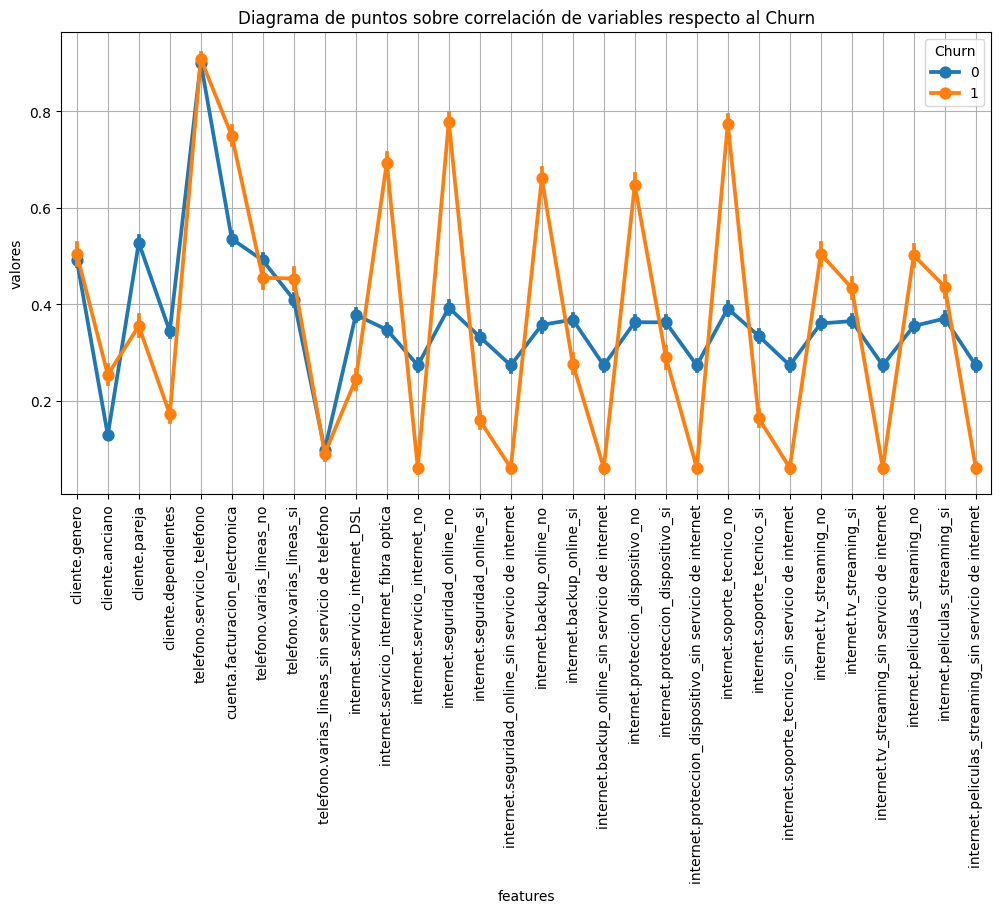

In [ ]:
diagrama_puntos(datos_churn, 0, 30)

In [ ]:
datos_churn.groupby('Churn')["telefono.servicio_telefono"].value_counts(normalize=True)

Churn  telefono.servicio_telefono
0      1                             0.901438
       0                             0.098562
1      1                             0.909043
       0                             0.090957
Name: proportion, dtype: float64

In [ ]:
datos_churn.groupby('Churn')["telefono.varias_lineas_sin servicio de telefono"].value_counts(normalize=True)

Churn  telefono.varias_lineas_sin servicio de telefono
0      0                                                  0.901438
       1                                                  0.098562
1      0                                                  0.909043
       1                                                  0.090957
Name: proportion, dtype: float64

De la visualización de los diagramas de violín y puntos, observamos que las columnas "telefono.servicio_telefono" y "telefono.varias_lineas_sin servicio de telefono" tienen alta correlación tanto cuando churl es 'si' o 'no' por lo que no aportan valor al modelo y las eliminaremos, luego volvemos a correr el modelo

In [ ]:
train_x_graph = train_x.drop(columns=["telefono.servicio_telefono","telefono.varias_lineas_sin servicio de telefono"])
test_x_graph = test_x.drop(columns=["telefono.servicio_telefono","telefono.varias_lineas_sin servicio de telefono"])
model = pronosticar(train_x_graph, train_y)
model.score(test_x_graph, test_y)

0.7950281425891182

## 4.2 Mapa de Calor

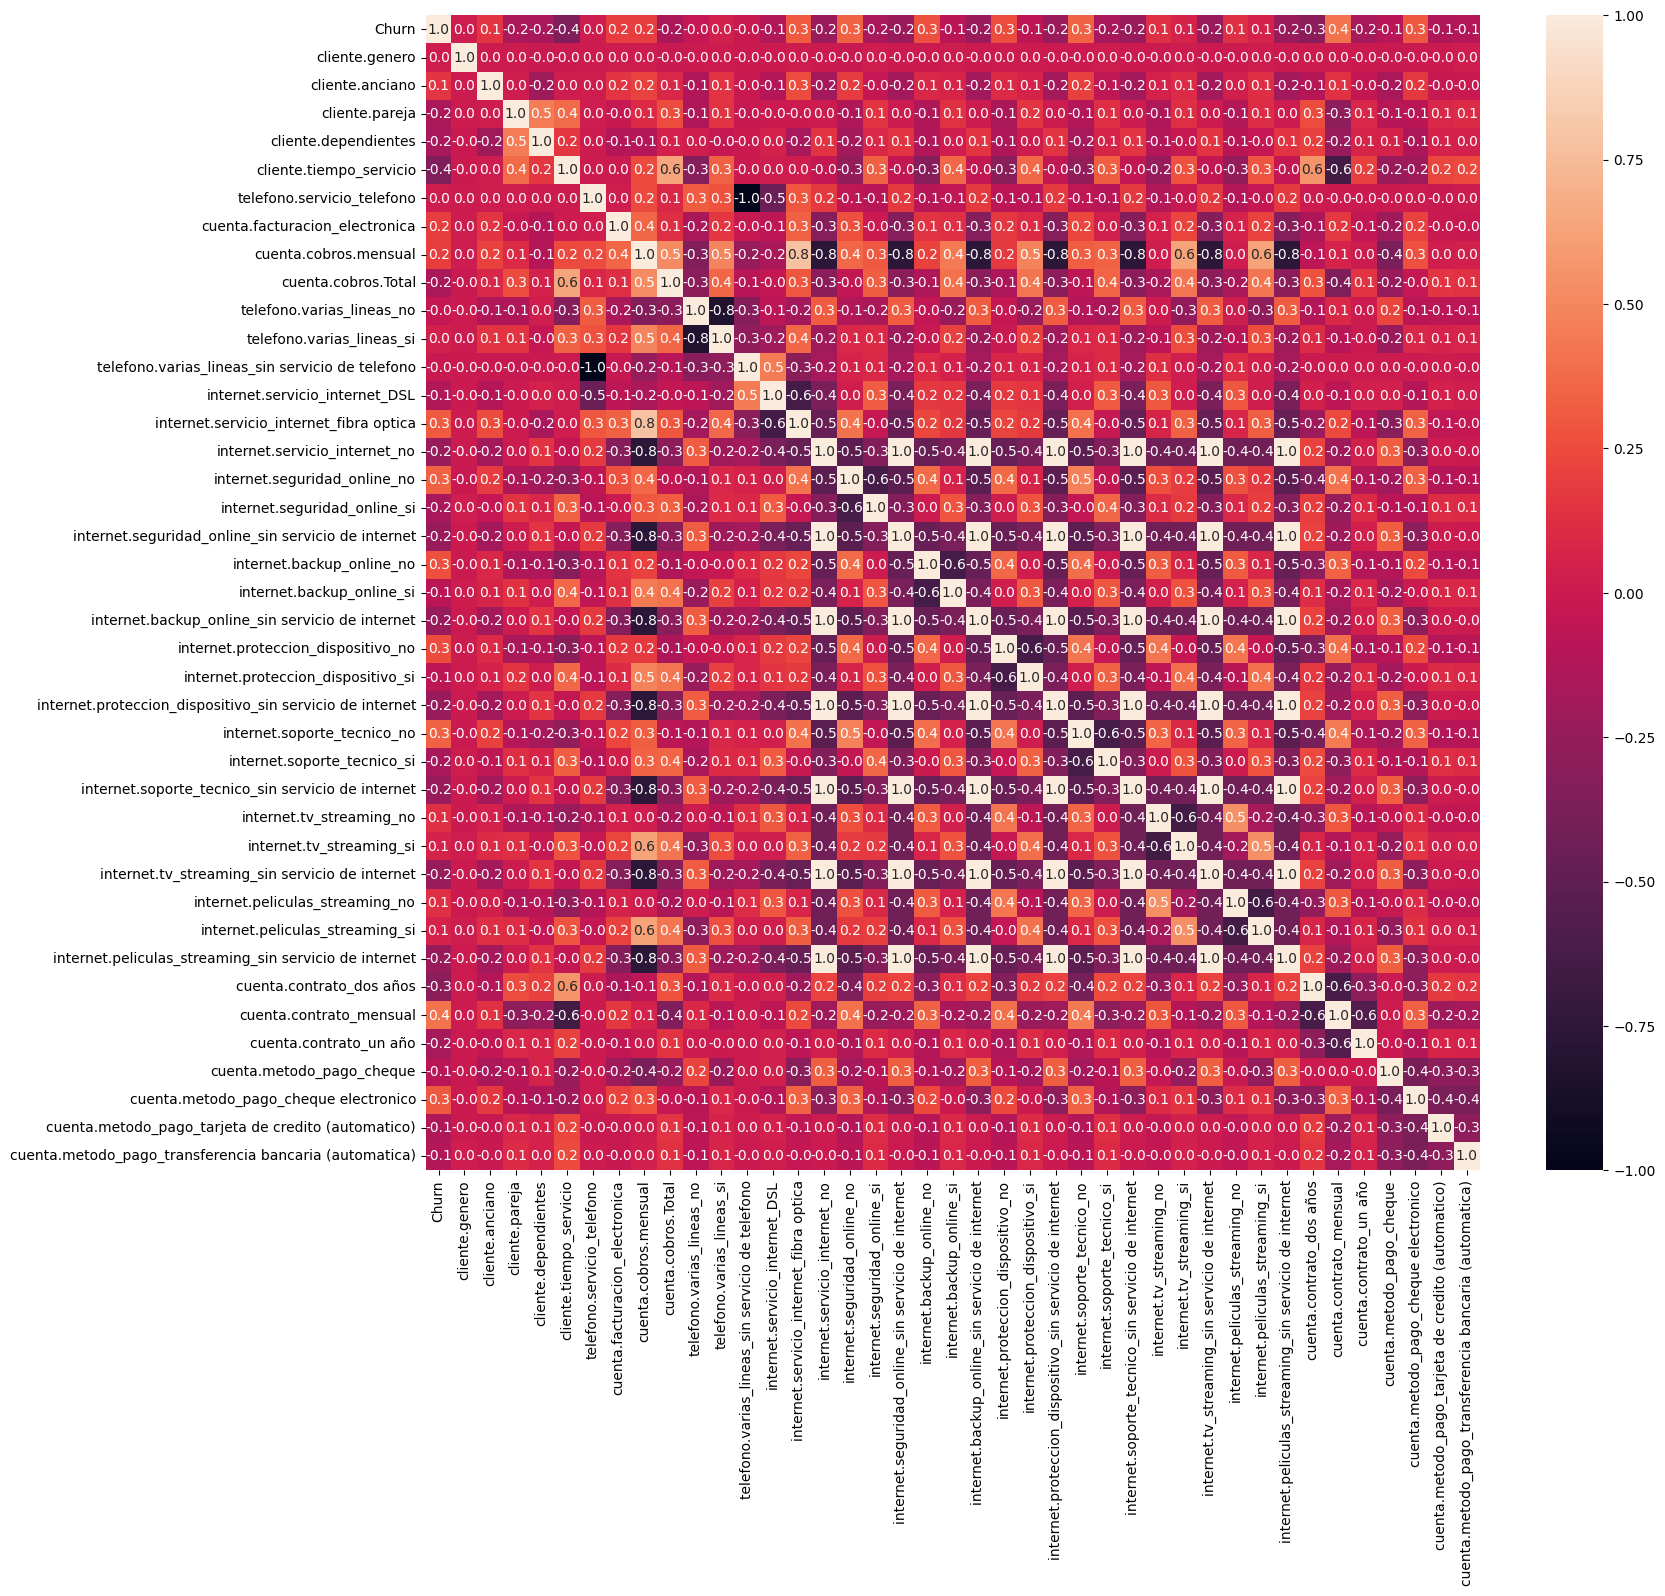

In [ ]:
def mapa_de_calor(df):
  grafico = df.corr()
  plt.figure(figsize=(17, 15))
  sns.heatmap(grafico, annot=True, fmt=".1f")
  return grafico

matriz = mapa_de_calor(datos_churn)

In [ ]:
matriz2 = (matriz > 0.99) | (matriz < -0.99)
matriz2 = matriz2.sum()
matriz2[matriz2>1]

,0
telefono.servicio_telefono,2
telefono.varias_lineas_sin servicio de telefono,2
internet.servicio_internet_no,7
internet.seguridad_online_sin servicio de internet,7
internet.backup_online_sin servicio de internet,7
internet.proteccion_dispositivo_sin servicio de internet,7
internet.soporte_tecnico_sin servicio de internet,7
internet.tv_streaming_sin servicio de internet,7
internet.peliculas_streaming_sin servicio de internet,7


Según el mapa de calor hay 7 columnas con alta correlación positiva(>0.99) y 2 con alta correlación negativa(<-0.99), eliminaremos estas variables excepto 'internet.servicio_internet_no' que considero que engloba a las demas correlaciones positivas y 'telefono.servicio_telefono' que engloba las correlaciones negativas.

In [ ]:
def identificar_variables(matriz):
  return matriz.index

identificar_variables(matriz2[matriz2>1])


Index(['telefono.servicio_telefono',
       'telefono.varias_lineas_sin servicio de telefono',
       'internet.servicio_internet_no',
       'internet.seguridad_online_sin servicio de internet',
       'internet.backup_online_sin servicio de internet',
       'internet.proteccion_dispositivo_sin servicio de internet',
       'internet.soporte_tecnico_sin servicio de internet',
       'internet.tv_streaming_sin servicio de internet',
       'internet.peliculas_streaming_sin servicio de internet'],
      dtype='object')

In [ ]:
train_x_heat = train_x.drop(columns=['internet.seguridad_online_sin servicio de internet',
       'internet.backup_online_sin servicio de internet',
       'internet.proteccion_dispositivo_sin servicio de internet',
       'internet.soporte_tecnico_sin servicio de internet',
       'internet.tv_streaming_sin servicio de internet',
       'internet.peliculas_streaming_sin servicio de internet',
       'telefono.varias_lineas_sin servicio de telefono'])
test_x_heat = test_x.drop(columns=['internet.seguridad_online_sin servicio de internet',
       'internet.backup_online_sin servicio de internet',
       'internet.proteccion_dispositivo_sin servicio de internet',
       'internet.soporte_tecnico_sin servicio de internet',
       'internet.tv_streaming_sin servicio de internet',
       'internet.peliculas_streaming_sin servicio de internet',
       'telefono.varias_lineas_sin servicio de telefono'])
model = pronosticar(train_x_heat, train_y)
model.score(test_x_heat, test_y)

0.7950281425891182

## 4.3 Feature Importances
Implementamos métodos de selección de características usando SelectKBest, RFE y
PCA para reducir la dimensionalidad del conjunto de datos.

### 4.3.1 SelectKBest:
Este método selecciona las mejores características según su relevancia estadística
usando la prueba chi-cuadrado. Es útil cuando se trabaja con datos categóricos y
selecciona las características más relevantes para el modelo.

In [ ]:
def pronosticar_kbest(train_x, train_y,test_x, test_y):
  mejor_k = 0
  mejor_score = 0
  mejores_columnas = []
  # Iterar sobre el rango de posibles valores de k (número de características)
  for k in range(1, train_x.shape[1] + 1):
    #Creamos el selector de mejores columnas usando el algoritmo kbest y el método estadístico chi cuadrado
    seleccionar_mejores = SelectKBest(chi2, k=25)
    seleccionar_mejores.fit(train_x, train_y)
    train_x_kbest = seleccionar_mejores.transform(train_x)
    model = RandomForestClassifier(random_state=50)
  # Validación cruzada
    scores = cross_val_score(model, train_x_kbest, train_y, cv=5,scoring='accuracy')
    score = np.mean(scores)
  # Verificar si se ha alcanzado una mejor precisión
    if score > mejor_score:
      mejor_k = k
      mejor_score = score
      mejor_seleccionador = seleccionar_mejores
      mejores_columnas = train_x.columns[mejor_seleccionador.get_support()] # Nombres de columnas
  # Ajustar el modelo con las mejores características
  mejor_model = RandomForestClassifier(random_state=50)
  mejor_model.fit(mejor_seleccionador.transform(train_x), train_y)
  test_x_kbest = mejor_seleccionador.transform(test_x)
  #mejor_model.fit(train_x_kbest, train_y)
  test_score = mejor_model.score(test_x_kbest, test_y)
  print(f"Utilizando SelectKBest:")
  print(f"El mejor número de características seleccionadas es {len(mejores_columnas)} con un score de {test_score:.4f}")
  print(f"Las columnas más importantes son: {mejores_columnas}")



pronosticar_kbest(train_x, train_y,test_x, test_y)

Utilizando SelectKBest:
El mejor número de características seleccionadas es 25 con un score de 0.7889
Las columnas más importantes son: Index(['cliente.anciano', 'cliente.dependientes', 'cliente.tiempo_servicio',
       'cuenta.facturacion_electronica', 'cuenta.cobros.mensual',
       'cuenta.cobros.Total', 'internet.servicio_internet_fibra optica',
       'internet.servicio_internet_no', 'internet.seguridad_online_no',
       'internet.seguridad_online_si',
       'internet.seguridad_online_sin servicio de internet',
       'internet.backup_online_no',
       'internet.backup_online_sin servicio de internet',
       'internet.proteccion_dispositivo_no',
       'internet.proteccion_dispositivo_sin servicio de internet',
       'internet.soporte_tecnico_no', 'internet.soporte_tecnico_si',
       'internet.soporte_tecnico_sin servicio de internet',
       'internet.tv_streaming_sin servicio de internet',
       'internet.peliculas_streaming_sin servicio de internet',
       'cuenta.contr

### 4.3.2 RFE (Recursive Feature Elimination):
Este algoritmo selecciona características eliminando recursivamente las menos importantes según el modelo. Usa un clasificador (en este caso, RandomForest) para identificar y eliminar las características menos relevantes, dejando solo las más útiles. Es el único método de los 3 que vamos a utilizar, que requiere que los datos pasen primero por el modelo, por ello requiere más tiempo de ejecución

In [ ]:
def pronosticar_rfe(train_x, train_y,test_x, test_y):
  model = RandomForestClassifier(random_state=50)
  mejor_n = 0
  mejor_score = 0
  mejores_columnas = []
  # Iterar sobre el rango de posibles valores de n (número de características)
  for n in range(1, train_x.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=23)
    rfe.fit(train_x, train_y)
    train_x_rfe = rfe.transform(train_x)
    scores = cross_val_score(model, train_x_rfe, train_y, cv=5,scoring='accuracy')
    score = np.mean(scores)

    model = RandomForestClassifier(random_state=50)
  # Validación cruzada
    scores = cross_val_score(model, train_x_rfe, train_y, cv=5,scoring='accuracy')
    score = np.mean(scores)
  # Verificar si se ha alcanzado una mejor precisión
    if score > mejor_score:
      mejor_n = n
      mejor_score = score
      mejores_columnas = list(train_x.columns[rfe.support_])  # Nombres de columnas
      mejor_rfe = rfe
  # Ajustar el modelo con las mejores características
  mejor_model = RandomForestClassifier(random_state=50)
  train_x_rfe = mejor_rfe.transform(train_x)
  mejor_model.fit(train_x_rfe, train_y)
  test_x_rfe = mejor_rfe.transform(test_x)
  test_score = mejor_model.score(test_x_rfe, test_y)

  #mejor_model.fit(mejor_model.transform(train_x), train_y)
  #test_x_rfe = rfe.transform(test_x)
  #mejor_model.fit(train_x_kbest, train_y)
  #test_score = mejor_model.score(test_x_kbest, test_y)
  print(f"Utilizando RFE:")
  print(f"El mejor número de características seleccionadas es {len(mejores_columnas)} con un score de {test_score:.4f}")
  print(f"Las columnas más importantes son: {mejores_columnas}")



pronosticar_rfe(train_x, train_y,test_x, test_y)

Utilizando RFE:
El mejor número de características seleccionadas es 23 con un score de 0.7960
Las columnas más importantes son: ['cliente.genero', 'cliente.anciano', 'cliente.pareja', 'cliente.dependientes', 'cliente.tiempo_servicio', 'cuenta.facturacion_electronica', 'cuenta.cobros.mensual', 'cuenta.cobros.Total', 'telefono.varias_lineas_no', 'telefono.varias_lineas_si', 'internet.servicio_internet_fibra optica', 'internet.seguridad_online_no', 'internet.backup_online_no', 'internet.proteccion_dispositivo_no', 'internet.proteccion_dispositivo_si', 'internet.soporte_tecnico_no', 'internet.tv_streaming_no', 'internet.peliculas_streaming_si', 'cuenta.contrato_dos años', 'cuenta.contrato_mensual', 'cuenta.metodo_pago_cheque electronico', 'cuenta.metodo_pago_tarjeta de credito (automatico)', 'cuenta.metodo_pago_transferencia bancaria (automatica)']


### 4.3.3 PCA (Principal Component Analysis):
Este método transforma las características originales en un conjunto de nuevas
variables no correlacionadas llamadas componentes principales, que capturan la
mayor parte de la variabilidad de los datos, reduciendo la dimensionalidad sin perder
mucha información.

In [ ]:
# La primera regla del PCA es que nuestros datos deben ser simétricos, para asegurarnos eso, mormalizamos nuestros datos con StandarScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)
# Transformamos los datos normalizados a dataframe
train_x_scaled = pd.DataFrame(train_x_scaled, columns=train_x.columns)
test_x_scaled = pd.DataFrame(test_x_scaled, columns=test_x.columns)



In [ ]:
# Creamos la matriz de covarianza de train_x_scaled con la función numpy np.cov()
C = np.cov(train_x_scaled, rowvar=False)
# Comparamos la matriz creada con su transpuesta para verificar que sea simétrica
es_simetrica = np.allclose(C, C.T)
print(f'La matriz de covarianza es simétrica? {es_simetrica}')

La matriz de covarianza es simétrica? True


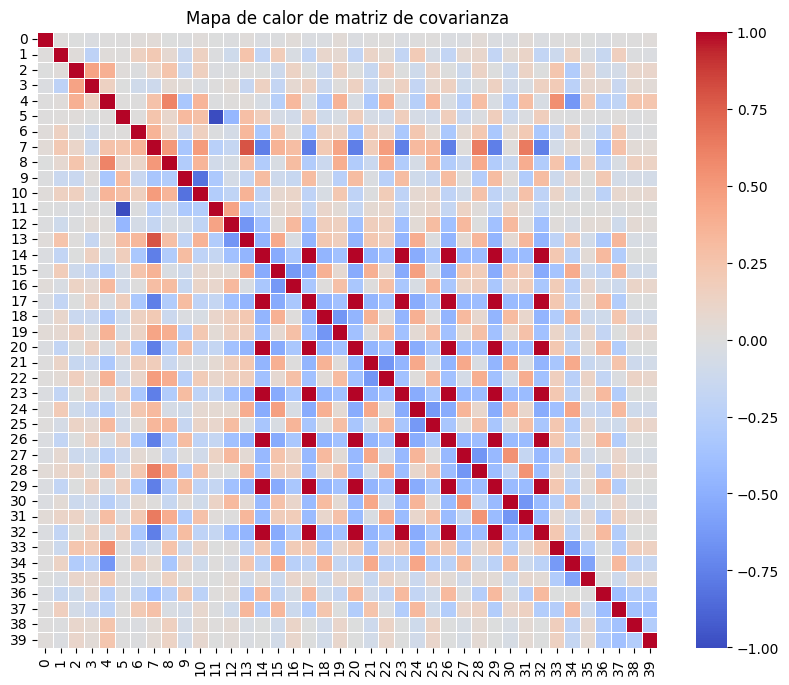

In [ ]:
# Creamos un mapa de calor para verificar visualmente la simetría de los datos
plt.figure(figsize=(10, 8))
sns.heatmap(C, annot=False, linewidths=0.5, cmap='coolwarm')
plt.title('Mapa de calor de matriz de covarianza')
plt.show()

Usando PCA:
El número de componentes es 22 con un score de: 78.61%
Total de varianza explicada por el PCA: 100.00%


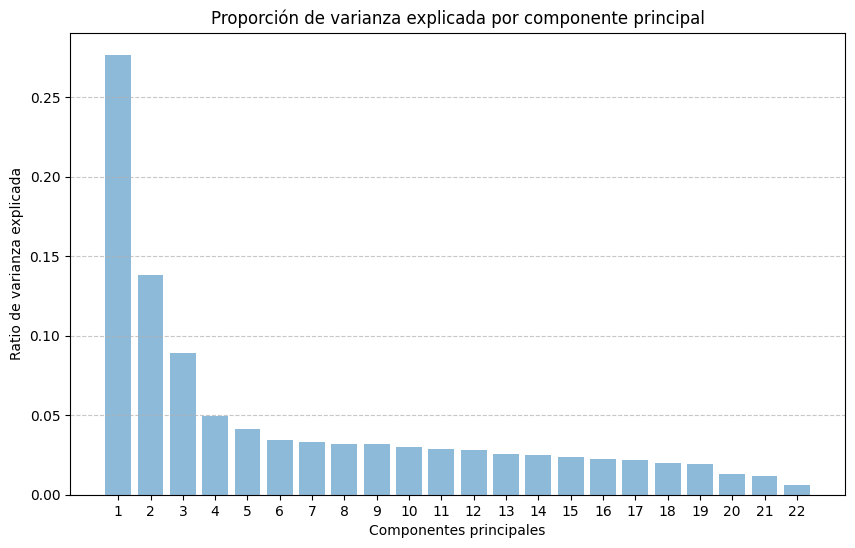

Cargas de los componentes:
                                                     PC1   PC2   PC3   PC4  \
cliente.genero                                     -0.02  0.03 -0.02 -0.01   
cliente.anciano                                    -0.24 -0.05 -0.23 -0.12   
cliente.pareja                                     -0.00  0.42  0.04  0.07   
cliente.dependientes                                0.18  0.24  0.17  0.11   
cliente.tiempo_servicio                            -0.06  0.81  0.07  0.06   
telefono.servicio_telefono                          0.14  0.09 -0.67  0.64   
cuenta.facturacion_electronica                     -0.38 -0.02 -0.24 -0.11   
cuenta.cobros.mensual                              -0.81  0.35 -0.41  0.10   
cuenta.cobros.Total                                -0.33  0.64 -0.10  0.09   
telefono.varias_lineas_no                           0.37 -0.35 -0.02  0.37   
telefono.varias_lineas_si                          -0.29  0.41 -0.38  0.01   
telefono.varias_lineas_sin servicio d

In [ ]:
# Creamos la función para PCA
def pronosticar_PCA(train_x, test_x, train_y, test_y):
  n = 22
  pca = PCA(n_components= n)
  train_x_pca = pca.fit_transform(train_x)
  model = RandomForestClassifier(random_state=50)
  model.fit(train_x_pca, train_y)
  test_x_pca = pca.transform(test_x)
  test_score = model.score(test_x_pca, test_y)
  print('Usando PCA:')
  print(f"El número de componentes es {n} con un score de: {test_score *100:.2f}%")
  # Mostrar la varianza explicada
  total_varianza = sum(pca.explained_variance_ratio_)
  print(f'Total de varianza explicada por el PCA: {total_varianza *100:.2f}%')
  # Visualizamos el explained_variance_ratio
  plt.figure(figsize=(10, 6))
  plt.bar(range(1, n+1), pca.explained_variance_ratio_, alpha=0.5, align='center')
  plt.ylabel('Ratio de varianza explicada')
  plt.xlabel('Componentes principales')
  plt.title('Proporción de varianza explicada por componente principal')
  plt.xticks(np.arange(1, n+1,1))
  plt.grid(axis='y',linestyle='--',alpha=0.7)
  plt.show()
  # Obtenemos las cargas de los componentes:
  loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
  component_names = [f'PC{i+1}' for i in range(n)]
  loadings_df = pd.DataFrame(loadings, columns=component_names, index=train_x.columns)
  print('Cargas de los componentes:')
  print(loadings_df.round(2))
  #


pronosticar_PCA(train_x_scaled, test_x_scaled, train_y, test_y)


